# Setup

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
import math
import sys

In [ ]:
opentrngdir = "<pathto>/opentrng_ptrng/"
sys.path.append(opentrngdir+"analysis")
sys.path.append(opentrngdir+"emulator")
import emulator
import binutils
import entropy
import autocorrelation
import lsne

## Parameters

### Hardware target settings

#### Xilinx Artix 7

In [4]:
ts_xa7 = 0.11e-9
th_xa7 = 0.18e-9
metabias_xa7 = 0.9
a1_xa7 = emulator.A1_F100M
a2_xa7 = emulator.A2_F100M

#### FD-SOI 28nm

In [ ]:
# DFFQX4
ts_fd28 = 31.90e-12
th_fd28 = 18.37e-12
metabia_fd28 = 0.53
a1_fd28 = emulator.A1_F500M
a2_fd28 = emulator.A2_F500M

### Figures settings

In [ ]:
cm = 1/2.54  # centimeters in inches
width = 14*cm
height = 10*cm
half_size_factor = 1.8
plt.rcParams['figure.figsize']=[width, height]
plt.rcParams['savefig.transparent']=True
bbox = 'tight'
pad = 0

# ERO

In [6]:
def gen_ero(n, d, f0, f1, a1, a2, ts, th, metabias):
	bits, valid, resolved = np.array([]), np.array([]), np.array([])
	while len(bits) < n:
		ro0 = emulator.generate_periods(emulator.GENPERIODS, f0, a1, a2)
		ro1 = emulator.generate_periods(emulator.GENPERIODS, f1, a1, a2)
		b, v, r = emulator.ero(d, ro0, ro1, ts, th, metabias)
		bits, valid, resolved = np.append(bits, b), np.append(valid, v), np.append(resolved, r)
	return bits[:n].astype(int), valid[:n].astype(int), resolved[:n].astype(int)

In [7]:
def f_pvalid_ero(f, ts, th):
	return 1-(2*(ts+th))*f

## Probability of sampling with valid timing constraints (Pvalid)

In [8]:
fixed = 103.561e6
sweep = np.linspace(74.187673*1e6, 119.1198833*1e6, 59)
div = 1000
bitcount = 10_000

In [ ]:
f0 = fixed
f1 = sweep
pvalid_f1 = np.array([np.sum(gen_ero(bitcount, div, f0, f, a1_xa7, a1_xa7, ts_xa7, th_xa7, metabias_xa7)[1])/bitcount for f in f1])

In [ ]:
f0 = sweep
f1 = fixed
pvalid_f0 = np.array([np.sum(gen_ero(bitcount, div, f, f1, a1_xa7, a2_xa7, ts_xa7, th_xa7, metabias_xa7)[1])/bitcount for f in f0])

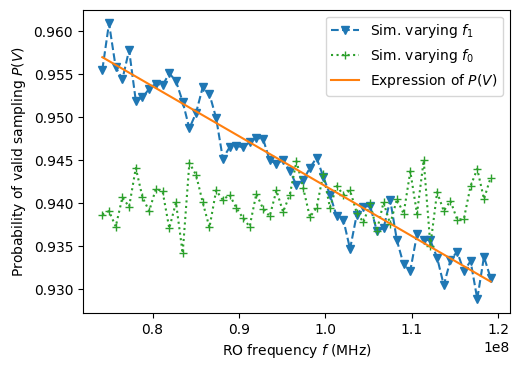

In [11]:
f = f0 # take the last sweep
plt.subplots(figsize=(width, height))
plt.plot(f, pvalid_f1, color='tab:blue', marker='v', linestyle='dashed', label=r'Sim. varying $f_1$')
plt.plot(f, pvalid_f0, color='tab:green', marker='+', linestyle='dotted', label=r'Sim. varying $f_0$')
plt.plot(f, [f_pvalid_ero(f1, ts_xa7, th_xa7) for f1 in f], color='tab:orange', label=r'Expression of $P(V)$')
plt.xlabel(r'RO frequency $f$ (MHz)')
plt.ylabel(r'Probability of valid sampling $P(V)$')
plt.legend()
plt.savefig('figures/ero_pv.pdf', bbox_inches=bbox, pad_inches=pad)
plt.show()

## Introduce bias in metastability resolution

In [12]:
bits, valid, resolved = gen_ero(100_000, 1000, 122e6, 121e6, a1_xa7, a2_xa7, ts_xa7, th_xa7, metabias_xa7)

In [13]:
np.sum(valid)/len(bits), len(bits)

(np.float64(0.929), 100000)

### Resove metastability to zero

In [14]:
bits, valid, resolved

(array([1, 1, 0, ..., 1, 1, 1]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([1, 1, 0, ..., 1, 1, 1]))

In [15]:
np.mean(bits), entropy.shannon(bits), entropy.markov(bits), entropy.mcv(bits)

(np.float64(0.50173),
 np.float64(0.9999913642987937),
 0.8104466201100645,
 0.9833532434046264)

In [16]:
np.mean(resolved), entropy.shannon(resolved), entropy.markov(resolved), entropy.mcv(resolved)

(np.float64(0.46599),
 np.float64(0.9966599483442887),
 0.654241281452294,
 0.8941252908039745)

## Maximum entropy

In [17]:
def hmax_ero(f1min, f1max, ts, th, metabias):
	f1 = np.linspace(f1min, f1max, 100, dtype=int)
	hmax_t = np.array([])
	for f in f1:
		p0v = 0.5
		p0nv = 1-metabias
		pev = f_pvalid_ero(f, ts, th)
		ppe0 = p0v * pev + p0nv * (1-pev)
		ppe1 = 1-ppe0
		hmax = -ppe0*math.log2(ppe0)-ppe1*math.log2(ppe1)
		hmax_t = np.append(hmax_t, hmax)
	return f1, hmax_t

In [ ]:
f1, hemax_f1 = hmax_ero(50e6, 200e6, ts_fd28, th_fd28, metabia_fd28)

In [19]:
np.min(hemax_f1)

np.float64(0.9999989500106294)

# MURO

In [20]:
def gen_muro(n, d, f, a1, a2, ts, th, metabias):
	bits, valid, resolved = np.array([]), np.array([]), np.array([])
	while len(bits) < n:
		ro0 = emulator.generate_periods(emulator.GENPERIODS, f[0], a1, a2)
		rox = np.empty((0, emulator.GENPERIODS))
		for fx in f[1:]:
			ro = emulator.generate_periods(emulator.GENPERIODS, fx, a1, a2)
			rox = np.vstack((rox, ro))
		b, v, r = emulator.muro(d, ro0, rox, ts, th, metabias)
		bits, valid, resolved = np.append(bits, b), np.append(valid, v), np.append(resolved, r)
	return bits[:n].astype(int), valid[:n].astype(int), resolved[:n].astype(int)

In [21]:
def f_pvalid_muro(f, ts, th):
	return np.prod([1-2*(ts+th)*f1 for f1 in f[1:]])

## MURO(2)

### Probability of sampling with valid timing constraints (Pvalid)

In [22]:
f = [121.546415e6, 120.14286451e6, 123.201489e6]
bits, valid, resolved = gen_muro(10_000, 1000, f, a1_xa7, a2_xa7, ts_xa7, th_xa7, metabias_xa7)

In [23]:
np.sum(valid == 2)/100_000, np.sum((2-valid)%2 == 0)/100_000

(np.float64(0.08649), np.float64(0.08687))

In [24]:
f_pvalid_muro(f, ts_xa7, th_xa7)

np.float64(0.8638395936890401)

### Introduce bias in metastability resolution

#### Resove metastability to zero

In [25]:
bits, valid, resolved

(array([0, 0, 1, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([0, 0, 1, ..., 1, 1, 1]))

In [26]:
np.mean(bits), entropy.shannon(bits), entropy.markov(bits), entropy.mcv(bits)

(np.float64(0.5065),
 np.float64(0.9998780888350783),
 0.7874024652035104,
 0.9451412394272092)

In [27]:
np.mean(resolved), entropy.shannon(resolved), entropy.markov(resolved), entropy.mcv(resolved)

(np.float64(0.5026),
 np.float64(0.9999804946751426),
 0.8321077097823851,
 0.9560127146619615)

## MURO(7)

In [28]:
f = [121.546415e6, 117.128651e6, 118.00115e6, 119.7565481e6, 120.14286451e6, 122.178543e6, 123.201489e6, 124.95954e6]
bits, valid, resolved = gen_muro(10_000, 1000, f, a1_xa7, a2_xa7, ts_xa7, th_xa7, metabias_xa7)

In [29]:
np.mean(bits), entropy.shannon(bits), entropy.markov(bits), entropy.mcv(bits)

(np.float64(0.498),
 np.float64(0.9999884584088952),
 0.9899722116632083,
 0.9576927393824618)

In [30]:
np.mean(resolved), entropy.shannon(resolved), entropy.markov(resolved), entropy.mcv(resolved)

(np.float64(0.5058),
 np.float64(0.9999029333006981),
 0.9581148305206026,
 0.9470863466285478)

In [31]:
np.sum(valid == 7)/100_000

np.float64(0.06072)

In [32]:
f_pvalid_muro(f, ts_xa7, th_xa7)

np.float64(0.6014922202664363)

## MURO(t)

In [33]:
def muro_f(f0, n, eq=0, spread=0.567884684333e6):
	if eq == -1:
		return np.linspace(f0-spread*n, f0, n+1)
	elif eq == 0:
		return np.linspace(f0-spread*n/2, f0+spread*n/2, n+1)
	elif eq == +1:
		return np.linspace(f0, f0+spread*n, n+1)
	else:
		assert True

### Probability of sampling with valid timing constraints (Pvalid)

In [ ]:
def plot_muro_sim_pv(bitcount, f0, t, e, s, a1, a2, ts, th, marker, color, label):
	sim_t = np.array([])
	for n in t:
		f = muro_f(f0, n, e, s)
		print('n={:} f0={:} fi=[{:.2f}, {:.2f}]'.format(n, f0/1e6, np.min(f)/1e6, np.max(f)/1e6))
		print(f)
		bits, valid, resolved = gen_muro(bitcount, 1000, f, a1, a2, ts, th, 0)
		sim_t = np.append(sim_t, np.sum(valid==n)/bitcount)
	u = range(1, t[-1]+1)
	pv_u = [f_pvalid_muro(muro_f(f0, n, e, s), ts, th) for n in u]
	plt.plot(t, sim_t, color=color, marker=marker, linestyle='dashed')
	plt.plot(u, pv_u, color=color)

n=1 f0=120.0 fi=[118.73, 120.00]
[1.18732115e+08 1.20000000e+08]
n=5 f0=120.0 fi=[113.66, 120.00]
[1.13660577e+08 1.14928461e+08 1.16196346e+08 1.17464231e+08
 1.18732115e+08 1.20000000e+08]
n=10 f0=120.0 fi=[107.32, 120.00]
[1.07321153e+08 1.08589038e+08 1.09856923e+08 1.11124807e+08
 1.12392692e+08 1.13660577e+08 1.14928461e+08 1.16196346e+08
 1.17464231e+08 1.18732115e+08 1.20000000e+08]
n=20 f0=120.0 fi=[94.64, 120.00]
[9.46423063e+07 9.59101910e+07 9.71780757e+07 9.84459604e+07
 9.97138451e+07 1.00981730e+08 1.02249614e+08 1.03517499e+08
 1.04785384e+08 1.06053268e+08 1.07321153e+08 1.08589038e+08
 1.09856923e+08 1.11124807e+08 1.12392692e+08 1.13660577e+08
 1.14928461e+08 1.16196346e+08 1.17464231e+08 1.18732115e+08
 1.20000000e+08]
n=30 f0=120.0 fi=[81.96, 120.00]
[8.19634595e+07 8.32313442e+07 8.44992288e+07 8.57671135e+07
 8.70349982e+07 8.83028829e+07 8.95707676e+07 9.08386523e+07
 9.21065369e+07 9.33744216e+07 9.46423063e+07 9.59101910e+07
 9.71780757e+07 9.84459604e+07 9.97

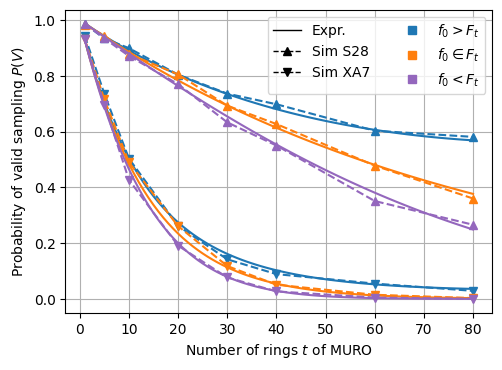

In [35]:
bitcount = 1_000
f0 = 120e6
t = [1, 5, 10, 20, 30, 40, 60, 80]
spread = [1.267884684333e6, 0.000567884684333e6]
plot_muro_sim_pv(bitcount, f0, t, -1, spread[0], a1_xa7, a2_xa7, ts_xa7, th_xa7, 'v', 'tab:blue', r'XA7, $f_0 > F_t$')
plot_muro_sim_pv(bitcount, f0, t,  0, spread[0], a1_xa7, a2_xa7, ts_xa7, th_xa7, 'v', 'tab:orange', r'XA7, $f_0 \in F_t$')
plot_muro_sim_pv(bitcount, f0, t, +1, spread[0], a1_xa7, a2_xa7, ts_xa7, th_xa7, 'v', 'tab:purple', r'XA7, $f_0 < F_t$')
plot_muro_sim_pv(bitcount, f0, t, -1, spread[0], a1_fd28, a2_fd28, ts_fd28, th_fd28, '^', 'tab:blue', r'S28, $f_0 > F_t$')
plot_muro_sim_pv(bitcount, f0, t,  0, spread[0], a1_fd28, a2_fd28, ts_fd28, th_fd28, '^', 'tab:orange', r'S28, $f_0 \in F_t$')
plot_muro_sim_pv(bitcount, f0, t, +1, spread[0], a1_fd28, a2_fd28, ts_fd28, th_fd28, '^', 'tab:purple', r'S28, $f_0 < F_t$')
plt.xlabel(r'Number of rings $t$ of MURO')
plt.ylabel(r'Probability of valid sampling $P(V)$')
plt.grid(visible=True, axis='both', which='major')
legend_elements = [
	Line2D([0], [0], color='black', lw=1, label='Expr.'),
	Line2D([0], [0], color='black', lw=1, ls='--', marker='^', label=r'Sim S28'),
	Line2D([0], [0], color='black', lw=1, ls='--', marker='v', label=r'Sim XA7'),
	Line2D([0], [0], marker='s', color='tab:blue', lw=0, label=r'$f_0 > F_t$'),
	Line2D([0], [0], marker='s', color='tab:orange', lw=0, label=r'$f_0 \in F_t$'),
	Line2D([0], [0], marker='s', color='tab:purple', lw=0, label=r'$f_0 < F_t$'),
]
plt.legend(handles=legend_elements, ncols=2)
plt.savefig('figures/muro_pv.pdf', bbox_inches=bbox, pad_inches=pad)
plt.show()

### Valid bit count distribution

In [36]:
bitcount = 1_000
n = 20
f = np.append(f0, np.linspace(f0-0.00064863*n*1e6, f0+0.00078931*n*1e6, n))
bits, valid, resolved = gen_muro(bitcount, 1000, f, a1_xa7, a2_xa7, ts_xa7, th_xa7, metabias_xa7)

In [37]:
np.sum(valid==n)/bitcount

np.float64(0.223)

## Maximum entropy

In [40]:
def hmax_muro(f0, ts, th, metabias):
	t = range(1, 100)
	hmax_t = np.array([])
	for n in t:
		p0v = 0.5
		p0nv = 1-metabias
		f = muro_f(f0, n)
		print(f)
		pmv = f_pvalid_muro(f, ts, th)
		ppm0 = p0v * pmv + p0nv * (1-pmv)
		ppm1 = 1-ppm0
		hemax = -ppm0*math.log2(ppm0)-ppm1*math.log2(ppm1)
		hmax_t = np.append(hmax_t, hemax)
	return t, hmax_t

[1.19716058e+08 1.20283942e+08]
[1.19432115e+08 1.20000000e+08 1.20567885e+08]
[1.19148173e+08 1.19716058e+08 1.20283942e+08 1.20851827e+08]
[1.18864231e+08 1.19432115e+08 1.20000000e+08 1.20567885e+08
 1.21135769e+08]
[1.18580288e+08 1.19148173e+08 1.19716058e+08 1.20283942e+08
 1.20851827e+08 1.21419712e+08]
[1.18296346e+08 1.18864231e+08 1.19432115e+08 1.20000000e+08
 1.20567885e+08 1.21135769e+08 1.21703654e+08]
[1.18012404e+08 1.18580288e+08 1.19148173e+08 1.19716058e+08
 1.20283942e+08 1.20851827e+08 1.21419712e+08 1.21987596e+08]
[1.17728461e+08 1.18296346e+08 1.18864231e+08 1.19432115e+08
 1.20000000e+08 1.20567885e+08 1.21135769e+08 1.21703654e+08
 1.22271539e+08]
[1.17444519e+08 1.18012404e+08 1.18580288e+08 1.19148173e+08
 1.19716058e+08 1.20283942e+08 1.20851827e+08 1.21419712e+08
 1.21987596e+08 1.22555481e+08]
[1.17160577e+08 1.17728461e+08 1.18296346e+08 1.18864231e+08
 1.19432115e+08 1.20000000e+08 1.20567885e+08 1.21135769e+08
 1.21703654e+08 1.22271539e+08 1.22839423e

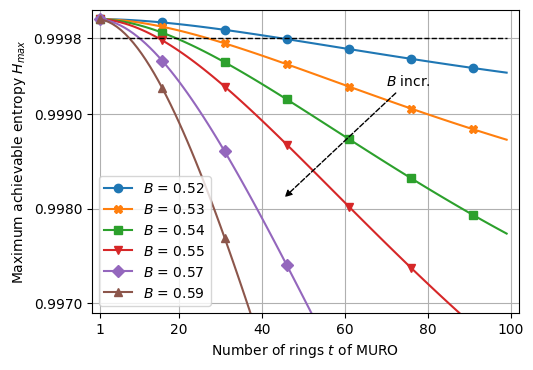

In [41]:
plt.subplots(figsize=(width, height))
B = [0.52, 0.53, 0.54, 0.55, 0.57, 0.59]
marker = ['o', 'X', 's', 'v', 'D', '^']
for i in range(0, len(B)):
	t, hmax_b_t = hmax_muro(120e6, ts_fd28, th_fd28, B[i])
	plt.plot(t, hmax_b_t, label=r'$B$ = '+str(B[i]), marker=marker[i], markevery=15)
plt.plot(t, 0.9998*np.ones(len(t)), linestyle='--', color='black', linewidth=1)
plt.xlabel(r'Number of rings $t$ of MURO')
plt.ylabel(r'Maximum achievable entropy $H_{max}$')
plt.annotate(text=r'$B$ incr.', xytext=(70, 0.9993), xy=(45, 0.9981), arrowprops=dict(ls='--', color='black', arrowstyle= '-|>'))
plt.xlim(1-2, 100+2)
plt.xticks([1, 20, 40, 60, 80, 100])
plt.ylim(0.997-0.0001, 1.0+0.0001)
plt.yticks([0.997 ,0.998, 0.999, 0.9998])
plt.grid(visible=True, which='major')
plt.legend()
plt.savefig('figures/muro_hmax_fd28.pdf', bbox_inches=bbox, pad_inches=pad)
plt.show()

[1.19716058e+08 1.20283942e+08]
[1.19432115e+08 1.20000000e+08 1.20567885e+08]
[1.19148173e+08 1.19716058e+08 1.20283942e+08 1.20851827e+08]
[1.18864231e+08 1.19432115e+08 1.20000000e+08 1.20567885e+08
 1.21135769e+08]
[1.18580288e+08 1.19148173e+08 1.19716058e+08 1.20283942e+08
 1.20851827e+08 1.21419712e+08]
[1.18296346e+08 1.18864231e+08 1.19432115e+08 1.20000000e+08
 1.20567885e+08 1.21135769e+08 1.21703654e+08]
[1.18012404e+08 1.18580288e+08 1.19148173e+08 1.19716058e+08
 1.20283942e+08 1.20851827e+08 1.21419712e+08 1.21987596e+08]
[1.17728461e+08 1.18296346e+08 1.18864231e+08 1.19432115e+08
 1.20000000e+08 1.20567885e+08 1.21135769e+08 1.21703654e+08
 1.22271539e+08]
[1.17444519e+08 1.18012404e+08 1.18580288e+08 1.19148173e+08
 1.19716058e+08 1.20283942e+08 1.20851827e+08 1.21419712e+08
 1.21987596e+08 1.22555481e+08]
[1.17160577e+08 1.17728461e+08 1.18296346e+08 1.18864231e+08
 1.19432115e+08 1.20000000e+08 1.20567885e+08 1.21135769e+08
 1.21703654e+08 1.22271539e+08 1.22839423e

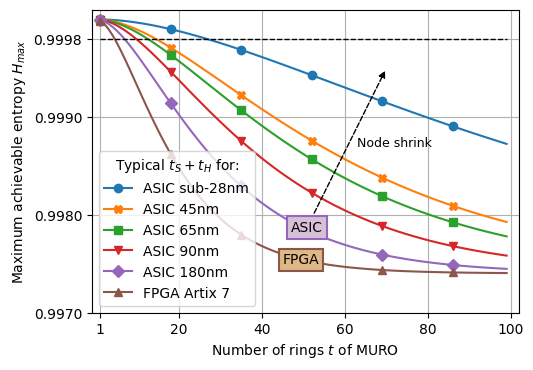

In [42]:
ts_180 = 139e-12
th_180 = 53.7e-12
ts_90 = 92e-12
th_90 = 45.5e-12
ts_65 = 84.2e-12
th_65 = 22.7e-12
ts_45 = 82.6e-12
th_45 = 10.2e-12
tsth = [ts_fd28+th_fd28, ts_45+th_45, ts_65+th_65, ts_90+th_90, ts_180+th_180, ts_xa7+th_xa7]
legend = ['ASIC sub-28nm', 'ASIC 45nm', 'ASIC 65nm', 'ASIC 90nm', 'ASIC 180nm', 'FPGA Artix 7']
marker = ['o', 'X', 's', 'v', 'D', '^']
plt.subplots(figsize=(width, height))
for i in range(0, len(tsth)):
	t, hmax_f_t = hmax_muro(120e6, tsth[i], 0, metabia_fd28)
	plt.plot(t, hmax_f_t, label=legend[i], marker=marker[i], markevery=17)
plt.plot(t, 0.9998*np.ones(len(t)), linestyle='--', color='black', linewidth=1)
plt.xlabel(r'Number of rings $t$ of MURO')
plt.ylabel(r'Maximum achievable entropy $H_{max}$')
plt.annotate(text='ASIC', xytext=(47, 0.99783), xy=(70, 0.9995), arrowprops=dict(ls='--', color='black', arrowstyle= '-|>'), bbox=dict(boxstyle="square,pad=0.3",fc='thistle', ec='tab:purple', lw=1.5))
plt.annotate(text='Node shrink', size=9, xy=(63, 0.9987))
plt.annotate(text='FPGA', xy=(45, 0.9975), bbox=dict(boxstyle="square,pad=0.3",fc='burlywood', ec='tab:brown', lw=1.5))
plt.xlim(1-2, 100+2)
plt.xticks([1, 20, 40, 60, 80, 100])
plt.ylim(0.997+0.0001, 1.00+0.0001)
plt.yticks([0.997 ,0.998, 0.999, 0.9998])
plt.grid(visible=True, which='major')
plt.legend(title=r'Typical $t_S+t_H$ for:')
plt.savefig('figures/reducing_metastability.pdf', bbox_inches=bbox, pad_inches=pad)
plt.show()

# COSO

In [43]:
f0 = 164.574500e6
f1 = 163.575000e6

In [44]:
ro0 = emulator.generate_periods(emulator.GENPERIODS, f0, a1_xa7, a2_xa7)
ro1 = emulator.generate_periods(emulator.GENPERIODS, f1, a1_xa7, a2_xa7)

In [ ]:
np.std(ro0), np.std(ro1)

(np.float64(2.939374693705722e-11), np.float64(2.948833345254522e-11))

In [46]:
coso = emulator.coso(ro0, ro1, False)

In [ ]:
np.mean(coso), len(coso)

(np.float64(69.23385812597793), 144438)

In [ ]:
thres = (ts_xa7+th_xa7)/np.abs(1/f0-1/f1)
perfect_coso = emulator.coso(ro0, ro1, False, thres)
np.mean(perfect_coso), thres, len(perfect_coso)

(np.float64(81.90482023792885), np.float64(7.810784805277737), 121633)

In [ ]:
bins = 50
data = np.loadtxt('data/coso_12_fpga_xilinx_a7.txt')

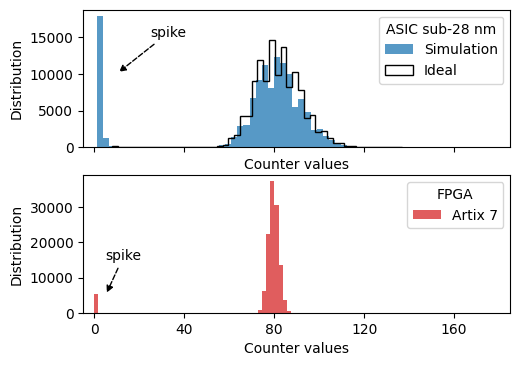

In [51]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(width, height))
ax1.hist(coso[:len(perfect_coso)], bins=bins, alpha=0.75, label='Simulation')
ax1.hist(perfect_coso, bins=bins, label='Ideal', histtype='step', color='k')
ax1.legend(title='ASIC sub-28 nm')
ax1.annotate(text='spike', xytext=(25, 15000), xy=(10, 10000), arrowprops=dict(ls='--', color='black', arrowstyle= '-|>'))
ax2.hist(data, bins=bins, color='tab:red', alpha=0.75, label='Artix 7')
ax2.legend(title='FPGA')
ax2.annotate(text='spike', xytext=(5, 15000), xy=(5, 5000), arrowprops=dict(ls='--', color='black', arrowstyle= '-|>'))
for ax in fig.get_axes():
	ax.label_outer()
	ax.set(xlabel='Counter values', ylabel='Distribution')
plt.xlim(0-5, 180+5)
plt.xticks([0 , 40, 80, 120, 160])
plt.savefig('figures/coso_sim_fpga.pdf', bbox_inches=bbox, pad_inches=pad)
plt.show()

# Entropy

In [52]:
from sympy import *

In [53]:
ts, th, t1, b = symbols('ts th t1 b')
p0v = 1/2
penv = 2*(ts+th)/t1
pev = 1 - penv
p1nv = b
p0nv = 1-p1nv
ppe0 = p0v * pev + p0nv * penv
ppe1 = 1-ppe0

In [54]:
ppe0

0.5 + (1 - b)*(2*th + 2*ts)/t1 - 0.5*(2*th + 2*ts)/t1

In [55]:
ppe1

0.5 - (1 - b)*(2*th + 2*ts)/t1 + 0.5*(2*th + 2*ts)/t1

In [56]:
i, t = symbols('i t')
T = Function('T')
pmv = product(1-2*(ts+th)/T(i), (i, 1, t))
pmnv = 1 - pmv

In [57]:
pmv

Product((-2*th - 2*ts)/T(i) + 1, (i, 1, t))

In [58]:
ppm0 = p0v * pmv + p0nv * pmnv
ppm1 = 1-ppm0

In [59]:
ppm0

(1 - b)*(1 - Product((-2*th - 2*ts)/T(i) + 1, (i, 1, t))) + 0.5*Product((-2*th - 2*ts)/T(i) + 1, (i, 1, t))

In [60]:
ppm1

-(1 - b)*(1 - Product((-2*th - 2*ts)/T(i) + 1, (i, 1, t))) - 0.5*Product((-2*th - 2*ts)/T(i) + 1, (i, 1, t)) + 1